In [1]:
import UWGeodynamics as GEO
import numpy as np
import math as math
from scipy.linalg import solve as linSolve
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.signal as sig
from scipy.linalg import solve as linSolve
from scipy.interpolate import interp1d
from mpi4py import MPI
import glucifer

comm = MPI.COMM_WORLD
CPUsize = comm.Get_size()

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

velocity = 1. * u.centimeter / u.year
model_length = 120. * u.kilometer
bodyforce = 2400. * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling["[length]"] = KL
GEO.scaling["[time]"] = Kt
GEO.scaling["[mass]"] = KM

In [3]:
class BasicHillSlopeDiffsuion2d(object):
    def __init__(self,
                 Model=None,
                 airIndex=None,
                 sedimentIndex=None,
                 diffusivity=None,
                 interfaceHeight=0.,
                 timeField=None,
                 filterTopo=False,
                 verbose=True):

        # Create references to Model variables
        self.materialField = Model.materialField
        self.airIndex = airIndex
        self.sedimentIndex = sedimentIndex
        self.Ks = diffusivity
        self.mesh=Model.mesh
        self.velocityField=Model.velocityField
        self.swarm=Model.swarm
        self.minX = GEO.nd(Model.minCoord[0])
        self.maxX = GEO.nd(Model.maxCoord[0])

        # Define the number of topographic markers, 4 times the Model mesh resolution
        self.topoNum = 4 * Model.elementRes[0] + 1
        self.topostp = (self.maxX - self.minX) / (self.topoNum - 1)
       
        #initiate the 1d FCT Grid for topographic diffusion
        self.gridt = np.zeros((6, self.topoNum))
        self.gridt[0, :] = np.linspace(self.minX, self.maxX, self.topoNum)
        self.gridt[1, :] = GEO.nd(interfaceHeight)
        self.filterTopo=filterTopo
        self.verbose = verbose

    def SurfaceVeloEval(self, mesh=None, velocityField=None):

        minX = self.minX
        maxX = self.maxX

        self.gridt[3:6, :] = 0.0

        tmp = np.where(
            (self.gridt[0, :] >= minX) & (self.gridt[0, :] <= maxX) &
            (self.gridt[0, :] >= mesh.data[0:mesh.nodesLocal, 0].min()) &
            (self.gridt[0, :] <= mesh.data[0:mesh.nodesLocal, 0].max())
            & (self.gridt[1, :] <= mesh.data[0:mesh.nodesLocal, 1].max()))[0]

        if len(tmp) > 0:
            tmp2 = velocityField.evaluate(np.squeeze(self.gridt[0:2, tmp]).T)
            self.gridt[3, tmp] = tmp2.T[0, :]
            self.gridt[4, tmp] = tmp2.T[1, :]

            tmp = np.where(
                (self.gridt[0, :] > minX) & (self.gridt[0, :] < maxX) &
                ((self.gridt[0, :] == mesh.data[0:mesh.nodesLocal, 0].min())
                 | (self.gridt[0, :] == mesh.data[0:mesh.nodesLocal, 0].max()))
            )[0]
            # boundary between two cpus, there velocity is reduced
            if len(tmp) > 0:
                # import ipdb; ipdb.set_trace()
                print 'hgn', tmp, self.gridt[0:2, tmp], np.squeeze(
                    self.gridt[0:2, tmp]).T
                if len(tmp) == 1:
                    tmp2 = velocityField.evaluate((self.gridt[0, tmp][0],
                                                   self.gridt[1, tmp][0]))
                else:
                    tmp2 = velocityField.evaluate(
                        np.squeeze(self.gridt[0:2, tmp]).T)
                self.gridt[3, tmp] = tmp2.T[0, :] / 2.
                self.gridt[4, tmp] = tmp2.T[1, :] / 2.

    def SurfaceProcess(self, dt):

        Ks = self.Ks
        topoNum = self.topoNum
        topostp = self.topostp
        minX = self.minX
        maxX = self.maxX
        # refer to Collision.m in Chapter_17 of Gerya_numerical_geodynamics book
        # first advect topography vertically
        # and diffuse topography (downhill diffusion)
        L = np.zeros((topoNum, topoNum))
        R = np.zeros((topoNum, 1))
        # first point: symmetry
        L[0, 0] = 1.
        L[0, 1] = -1.
        R[0] = 0.0
        # from IPython.core.debugger import Tracer; Tracer()()
        # Intermediate Points
        K2 = Ks * dt / topostp**2
        for i1 in range(1, topoNum - 1):
            # Internal points
            if (self.gridt[0, i1] >= minX and self.gridt[0, i1] <= maxX):
                L[i1, i1 - 1] = -K2
                L[i1, i1] = 1 + 2 * K2
                L[i1, i1 + 1] = -K2
                R[i1] = self.gridt[1, i1] + self.gridt[4, i1] * dt
            else:
                # left of the left boundary
                if (self.gridt[0, i1] < minX):
                    L[i1, i1] = 1.
                    L[i1, i1 + 1] = -1.
                    R[i1] = 0

                # right of the right boundary
                if (self.gridt[0, i1] > maxX):
                    L[i1, i1] = 1.
                    L[i1, i1 - 1] = -1.
                    R[i1] = 0

        # last point: symmetry
        L[topoNum - 1, topoNum - 1] = 1.
        L[topoNum - 1, topoNum - 2] = -1.
        R[topoNum - 1] = 0.

        # solve matrix
        self.gridt[1, :] = np.squeeze(linSolve(L, R))
        # Second, advect topography horizontally
        vxmax = max(np.abs(self.gridt[
            3, :]))  # maximum horizontal velocity at topography nodes
        # defining topography advection timestep
        ntSP = 1
        dtSP = dt
        if vxmax > 0:
            dtSP = min(topostp / vxmax, dt)
            if dtSP < dt:
                ntSP = np.ceil(dt / dtSP)
                dtSP = dt / ntSP

        # define FCT parameter MU
        mu = 1.0 / 8
        # advect topography with FCT
        for i1 in range(ntSP):
            # step 0: set new profile
            self.gridt[2, :] = self.gridt[1, :]
            # step 1: Transport + numerical diffusion stage
            for i2 in range(1, topoNum - 1):
                # define FCT parameters EPS and NU
                eps = self.gridt[3, i2] * dtSP / topostp
                nu = 1. / 8 + eps**2 / 2.
                # change topo
                self.gridt[2, i2] = self.gridt[1, i2] - eps / 2 * (
                    self.gridt[1, i2 + 1] - self.gridt[1, i2 - 1]) + nu * (
                        self.gridt[1, i2 + 1] - 2 * self.gridt[1, i2] +
                        self.gridt[1, i2 - 1])

            # step 2: anti-difussion stage
            # anti-diffusion flow for the first cell
            self.gridt[5, 0] = 0
            for i2 in range(1, topoNum - 2):
                # corrected antidiffusion flow for current cell
                delt0 = self.gridt[2, i2] - self.gridt[2, i2 - 1]
                delt1 = self.gridt[2, i2 + 1] - self.gridt[2, i2]
                delt2 = self.gridt[2, i2 + 2] - self.gridt[2, i2 + 1]
                s = np.copysign(1.0, delt1)
                self.gridt[5, i2] = s * max(
                    0.0, min(min(s * delt2, s * delt0), mu * abs(delt1)))
                self.gridt[
                    1,
                    i2] = self.gridt[2, i2] - self.gridt[5,
                                                         i2] + self.gridt[5, i2
                                                                          - 1]

        # Filter/Moving average to remove smale scale instabilities
        # for certain values of Ks or when dt is large
       # 
        if self.filterTopo:
            self.gridt[1, :] = sig.savgol_filter(self.gridt[1, :], 3, 1, mode='nearest')
        return

    def ErosionAndSedimentation(self):

        airIndex = self.airIndex
        sedimentIndex = self.sedimentIndex
        
        #generate an interpolation function, nearest seems to be the fastest option, refer to linkage module.
        surface_function = interp1d(
            self.gridt[0, :], self.gridt[1, :], kind='nearest')
        swarm_coords = self.swarm.particleCoordinates.data
        surface_ycoord = surface_function(swarm_coords[:, 0])
        material_flags = swarm_coords[:, 1] < surface_ycoord

        # convert air to sediment
        sedimented_mask = np.logical_and(
            np.in1d(self.materialField.data, airIndex), material_flags)
        self.materialField.data[sedimented_mask] = sedimentIndex

        # convert sediment to air
        eroded_mask = np.logical_and(
            ~np.in1d(self.materialField.data, airIndex), ~material_flags)
        self.materialField.data[eroded_mask] = airIndex

        return

    def solve(self, dt):
        if comm.rank == 0 and self.verbose:
            purple = "\033[0;35m"
            endcol = "\033[00m"
            print(purple +
                  "Processing surface with BasicHillSlopeDiffsuion2d" + endcol)

        self.SurfaceVeloEval(
            mesh=self.mesh, velocityField=self.velocityField)
        self.gridt[3:5, :] = comm.allreduce(self.gridt[3:5, :], op=MPI.SUM)

        comm.barrier()
        if comm.rank == 0:
            self.SurfaceProcess(dt)
        self.gridt[1, :] = comm.bcast(self.gridt[1, :], root=0)
        comm.barrier()
        self.ErosionAndSedimentation()
        comm.barrier()

        if comm.rank == 0 and self.verbose:
            purple = "\033[0;35m"
            endcol = "\033[00m"
            print(purple +
                  "Processing surface with BasicHillSlopeDiffsuion2d" + endcol)
        return

In [4]:
Model = GEO.Model(
    elementRes=(240, 30),
    minCoord=(0. * u.kilometer, -6. * u.kilometer),
    maxCoord=(120. * u.kilometer, 9. * u.kilometer),
    gravity=(0.0, -9.81 * u.meter / u.second**2))
Model.outputDir = "lowresThrustWedge_r"

In [5]:
Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

In [6]:
stickyAirLayer = Model.add_material(
    name="Sticky Air",
    shape=GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer))
plasticLayer = Model.add_material(
    name="Plastic",
    shape=GEO.shapes.Layer(top=stickyAirLayer.bottom, bottom=-5 * u.kilometer))
frictLayer = Model.add_material(
    name="Decol",
    shape=GEO.shapes.Layer(top=plasticLayer.bottom, bottom=-5.5 * u.kilometer))
rigidBase = Model.add_material(
    name="Ridid Base Layer",
    shape=GEO.shapes.Layer(top=frictLayer.bottom, bottom=Model.bottom))
sediment = Model.add_material(name="Sediment")


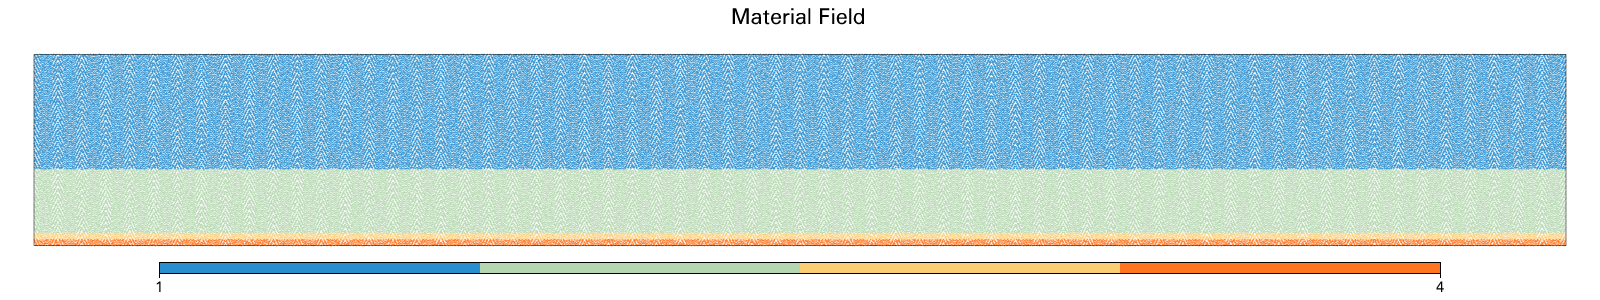

'Materials_initial.png'

In [7]:
Model.plot.material(figsize=(1600, 300), fn_size=2).save("Materials_initial")

In [8]:
stickyAirLayer.density = 1. * u.kilogram / u.metre**3
plasticLayer.density = 2400. * u.kilogram / u.metre**3
frictLayer.density = 2400. * u.kilogram / u.metre**3
rigidBase.density = 2400. * u.kilogram / u.metre**3
sediment.density = 2400. * u.kilogram / u.metre**3 

In [9]:
stickyAirLayer.viscosity = GEO.ConstantViscosity(1e18 * u.pascal * u.second)
rigidBase.viscosity = GEO.ConstantViscosity(1e23 * u.pascal * u.second)
sediment.viscosity = GEO.ConstantViscosity(1e22 * u.pascal * u.second)

plasticLayer.minViscosity = 1e18 * u.pascal * u.second
frictLayer.minViscosity = 1e18 * u.pascal * u.second

In [10]:
plasticLayer.plasticity = GEO.DruckerPrager(
    cohesion=20 * u.megapascal,
    #cohesionAfterSoftening=3 * u.mpascal,
    frictionCoefficient=np.tan(np.radians(30.0)),
    #frictionAfterSoftening=np.tan(np.radians(15.0))
)

frictLayer.plasticity = GEO.DruckerPrager(
    cohesion=0.1 * u.megapascal,
    #cohesionAfterSoftening=0.01 * u.pascal,
    frictionCoefficient=np.tan(np.radians(25.0)),
    #frictionAfterSoftening=np.tan(np.radians(10.0))
)

sediment.plasticity = GEO.DruckerPrager(
    cohesion=20 * u.megapascal,
    #cohesionAfterSoftening=3 * u.mpascal,
    frictionCoefficient=np.tan(np.radians(30.0)),
    #frictionAfterSoftening=np.tan(np.radians(15.0))
)


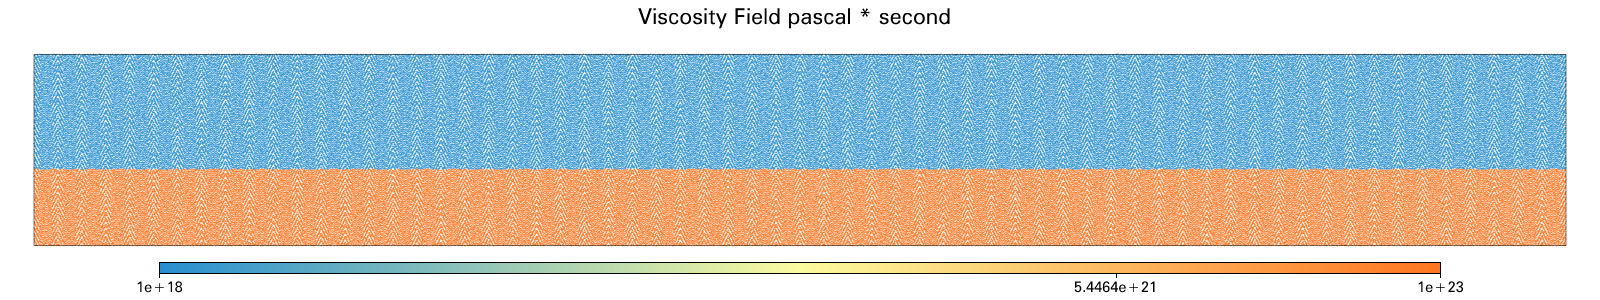

'Viscosity_initial.png'

In [11]:
Model.plot.viscosity(figsize=(1600, 300), fn_size=2).save("Viscosity_initial")

In [12]:
conditions = [(Model.y <= GEO.nd(rigidBase.top), GEO.nd(-velocity)),
              (True, GEO.nd(0. * u.centimeter / u.year))]

VelocityBcs = Model.set_velocityBCs(
    left=[conditions, 0.],
    right=[-velocity, None],
    top=[None, None],
    bottom=[-velocity, 0.])


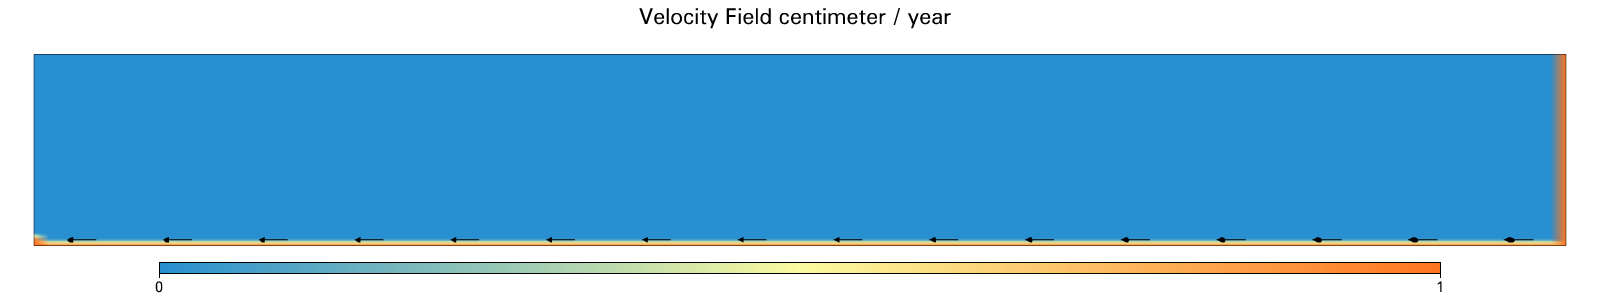

In [13]:
Fig = Model.plot.velocityField(figsize=(1600, 300),scaling=.3).save("Velocity_initial")

In [14]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6

In [15]:
Model.init_model()
Model.surfaceProcesses=BasicHillSlopeDiffsuion2d(Model=Model,airIndex=stickyAirLayer.index,sedimentIndex=sediment.index,diffusivity=GEO.nd(1e-8*u.metre**2/u.second),)

In [16]:
def plotFigures(fnSize=2,
                figSize=(int(Model.elementRes[0] * 4.5 + 10),
                         int(Model.elementRes[1] * 4.5 + 100))):


    figPlots = Model.plot.viscosity(
        figsize=figSize,
        colours='spectral',
        fn_size=fnSize,
        valueRange=[1e18, 1e24],
        fn_mask=Model.materialField > stickyAirLayer.index)
    figPlots.save(Model.outputDir + '/Viscosity_' + str(Model.time) + '.png')

    figPlots = Model.plot.material(
        figsize=figSize,
        fn_size=fnSize,
        valueRange=[plasticLayer.index, sediment.index],
        fn_mask=Model.materialField > stickyAirLayer.index)
    figPlots.save(Model.outputDir + '/Material_' + str(Model.time) + '.png')

    figPlots = Model.plot.plasticStrain(
        figsize=figSize,
        colours='gray',
        fn_size=fnSize,
        fn_mask=Model.materialField > stickyAirLayer.index,
        valueRange=[
            0, 4
        ])
    figPlots.save(Model.outputDir + '/PlasticStrain_' + str(Model.time) + '.png')
    del figPlots
    #FigSr = glucifer.Figure(
    #     figsize=figSize,
    #     quality=3,
    #     title="Strain Rate Field 1.0/seconds",
    #     #boundingBox=((0.0, -0.05), (1.0, 0.075))
    # )
    # fact = GEO.Dimensionalize(1.0, 1. / u.seconds).magnitude
    # FigSr.Points(
    #     Model.swarm,
    #     Model.strainRateField * fact,
    #     logScale=True,
    #     figsize=figSize,
    #     colours='spectral',
    #     valueRange=[1e-18, 1e-13],
    #     fn_mask=Model.materialField > stickyAirLayer.index,
    #     fn_size=fnSize)
    # FigSr.save(Model.outputDir + '/strainRate ' + str(Model.step) + '.png')
    return

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.005 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.01 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.015 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.02 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.025 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.03 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.035 megayear dt: 0.005 megayear
Processing surfa


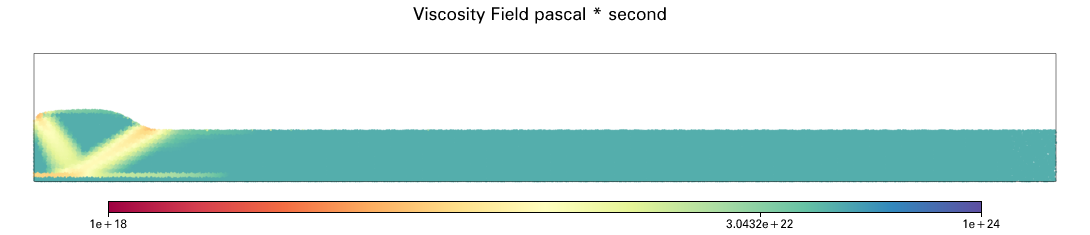


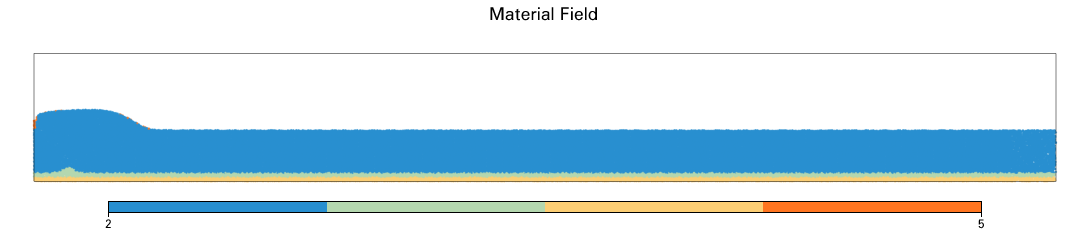


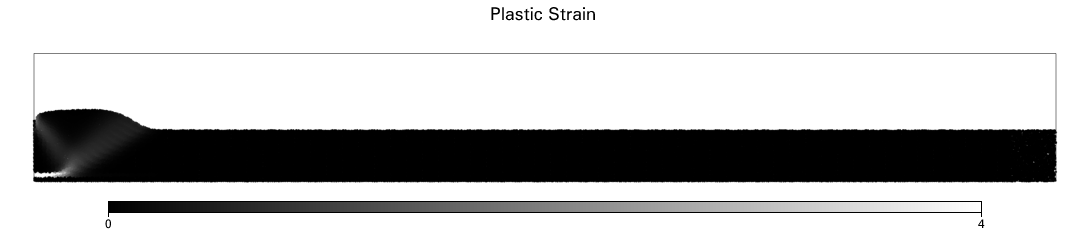

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.505 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.51 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.515 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.52 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.525 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.53 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  0.535 megayear dt: 0.005 megayear
Processing surfa


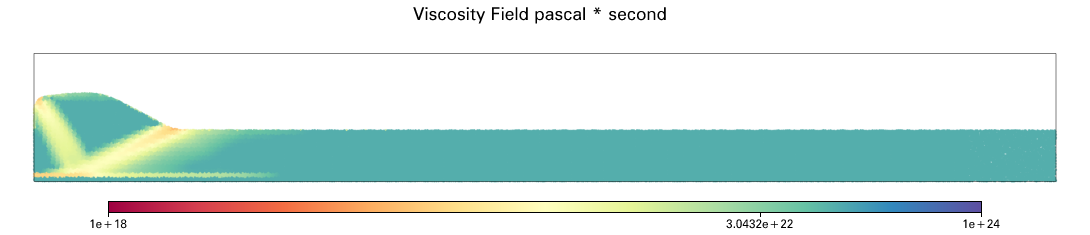


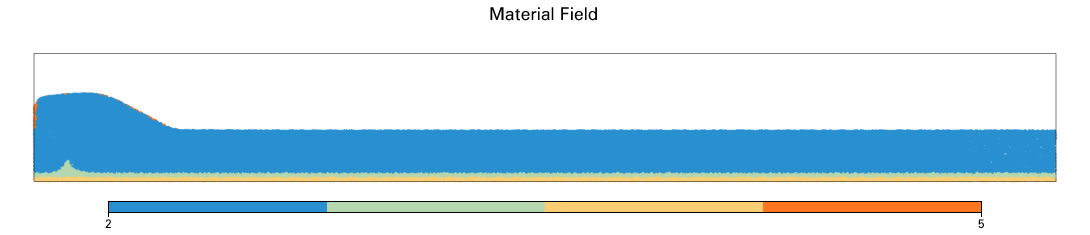


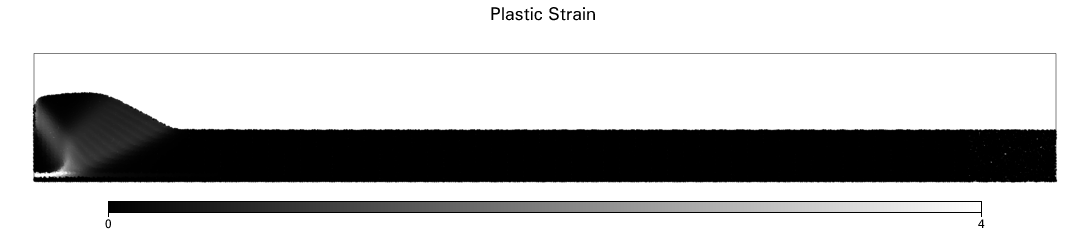

In [17]:
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.005 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.01 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.015 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.02 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.025 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.03 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.035 megayear dt: 0.005 megayear
Processing surfa


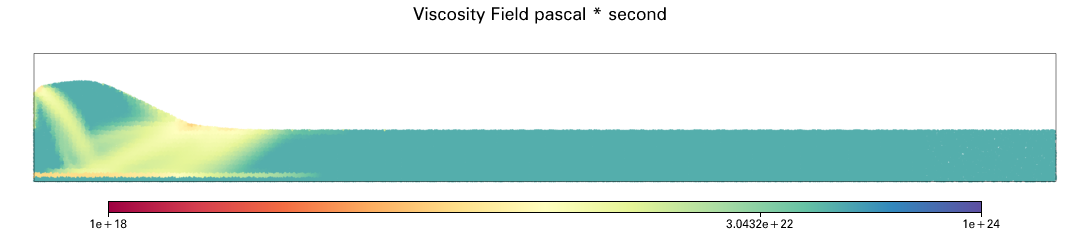


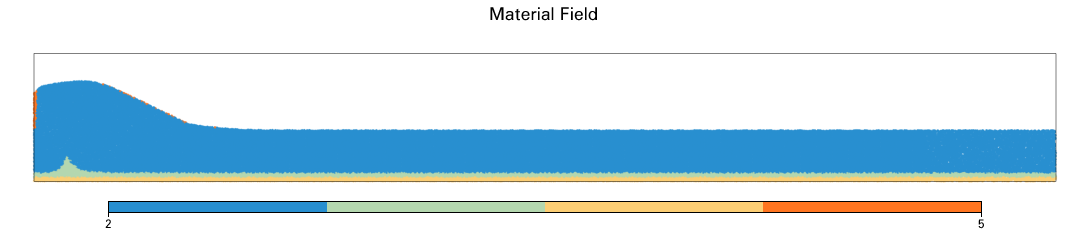


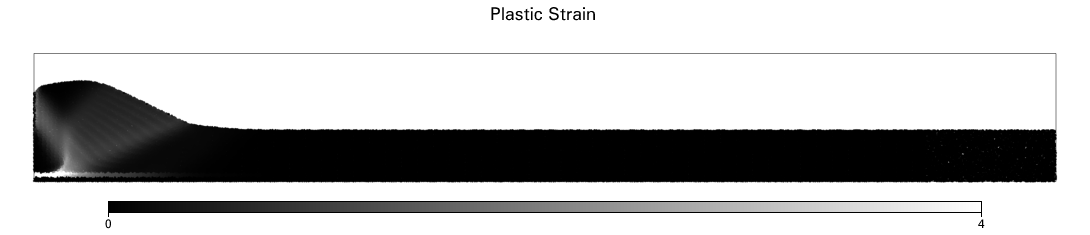

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.505 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.51 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.515 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.52 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.525 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.53 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  1.535 megayear dt: 0.005 megayear
Processing surfa


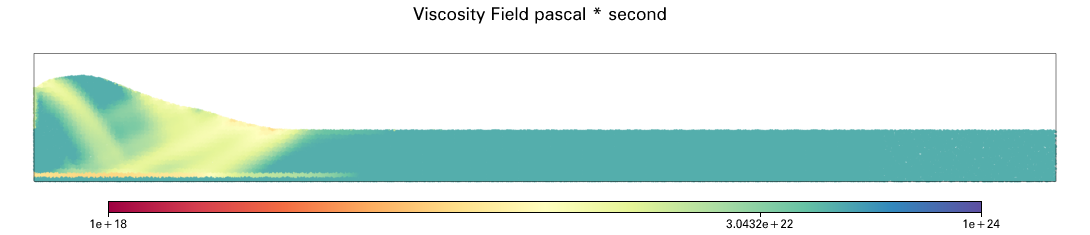


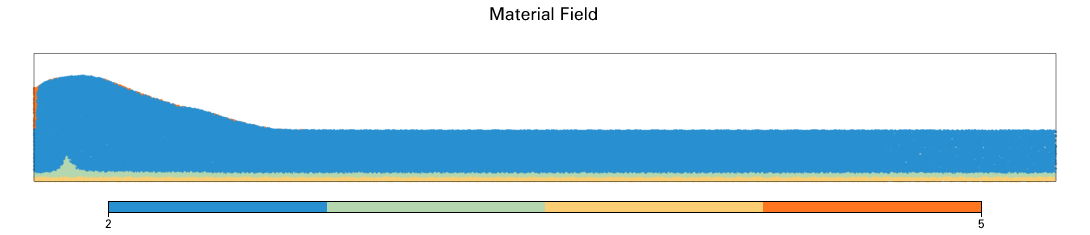


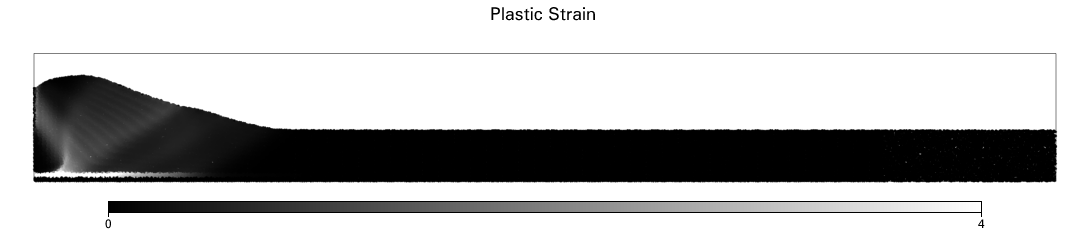

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.005 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.01 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.015 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.02 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.025 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.03 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.035 megayear dt: 0.005 megayear
Processing surfa


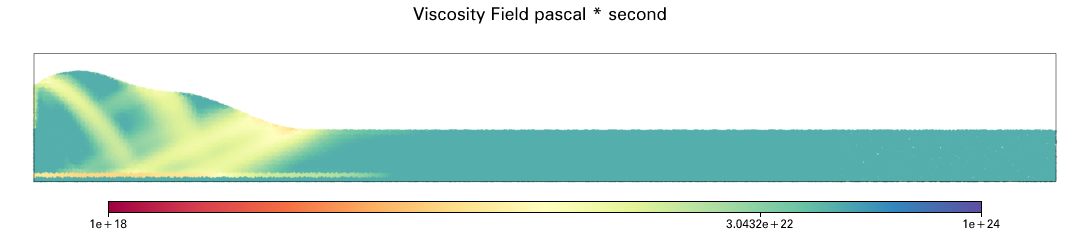


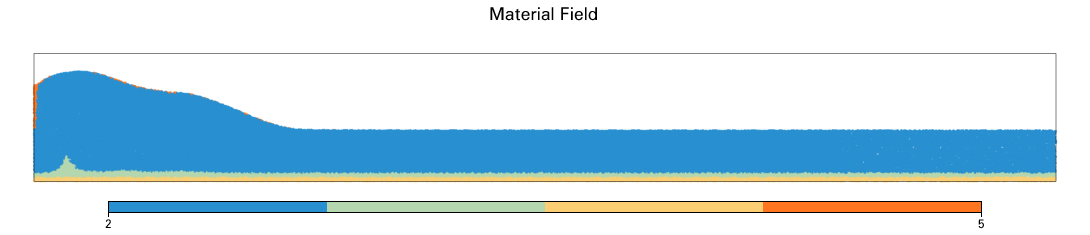


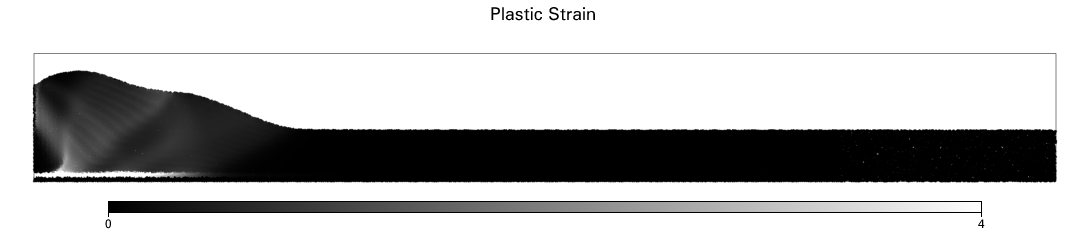

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.505 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.51 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.515 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.52 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.525 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.53 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  2.535 megayear dt: 0.005 megayear
Processing surfa


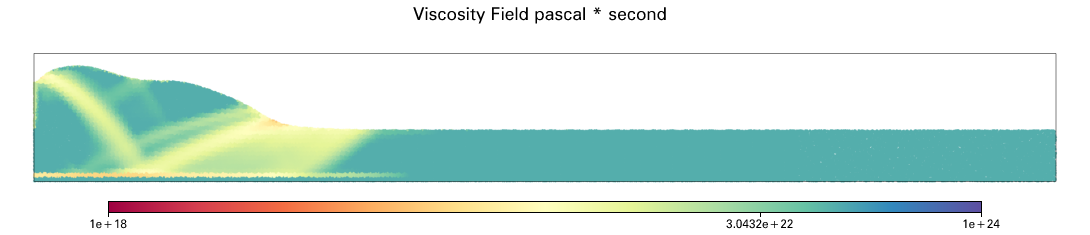


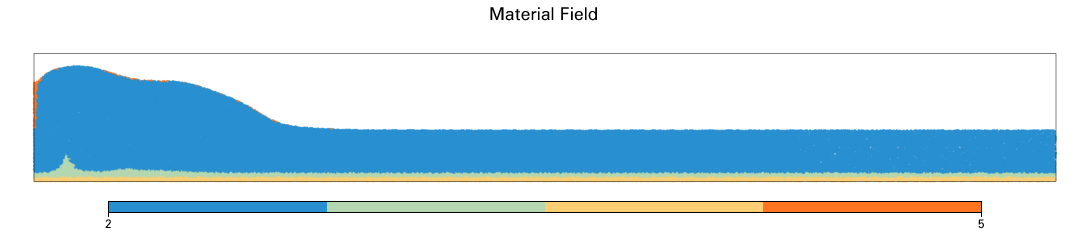


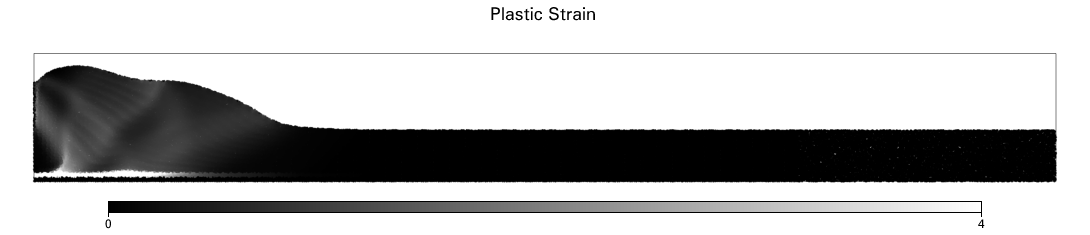

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.005 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.01 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.015 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.02 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.025 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.03 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.035 megayear dt: 0.005 megayear
Processing surfa


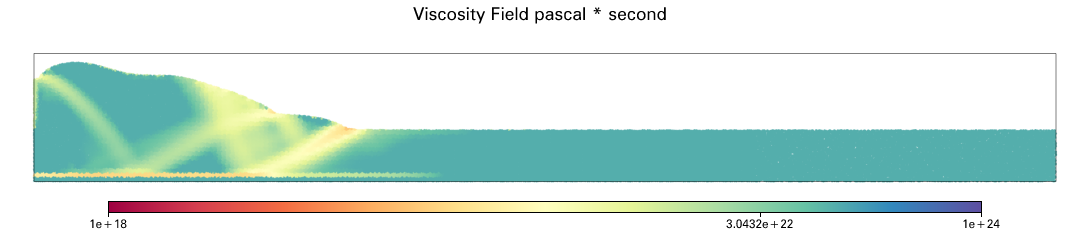


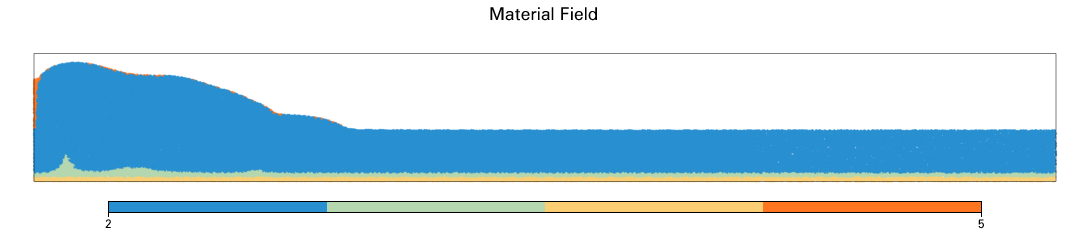


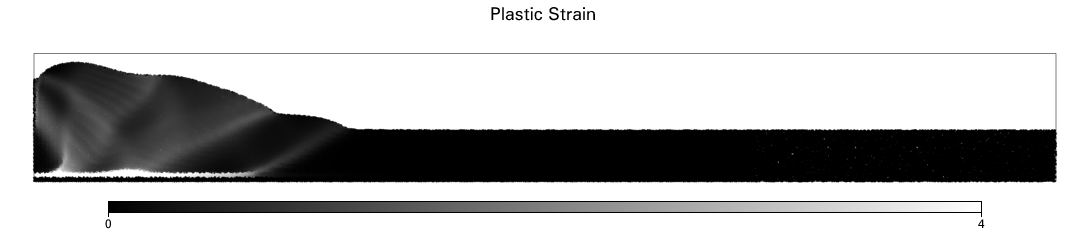

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.505 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.51 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.515 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.52 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.525 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.53 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  3.535 megayear dt: 0.005 megayear
Processing surfa


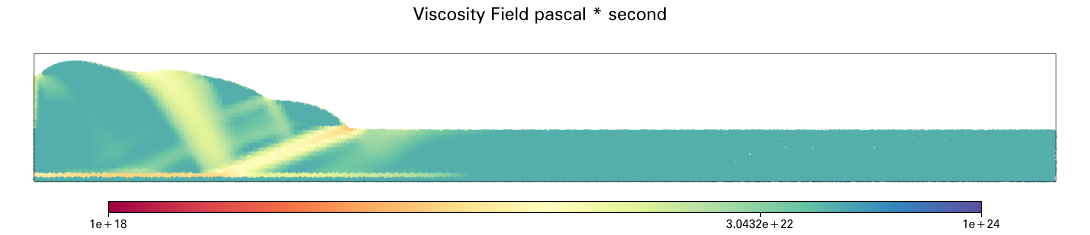


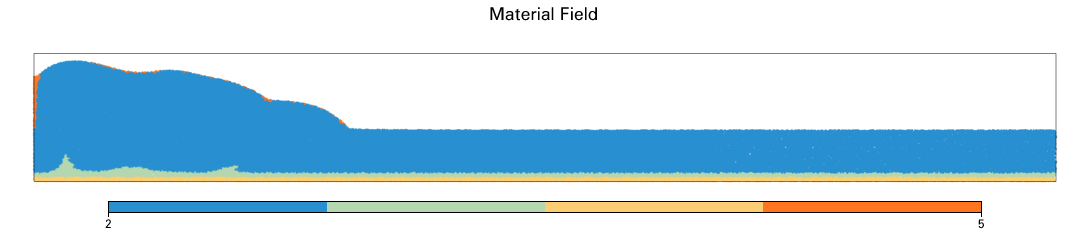


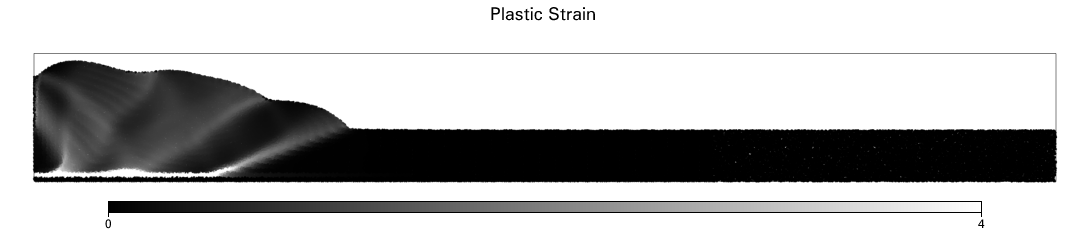

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.005 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.01 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.015 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.02 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.025 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.03 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.035 megayear dt: 0.005 megayear
Processing surfa


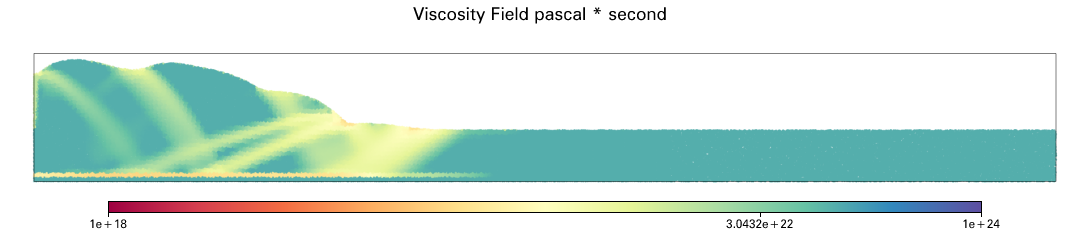


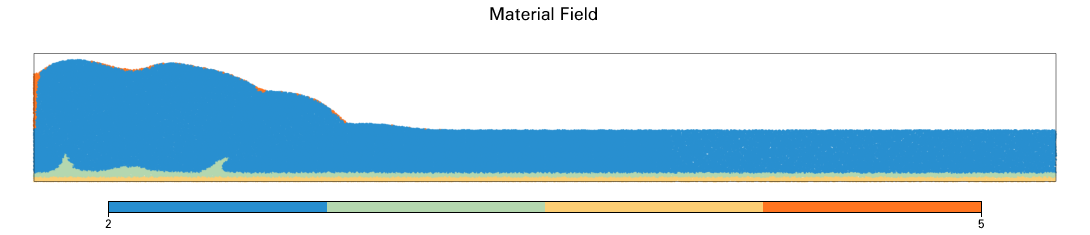


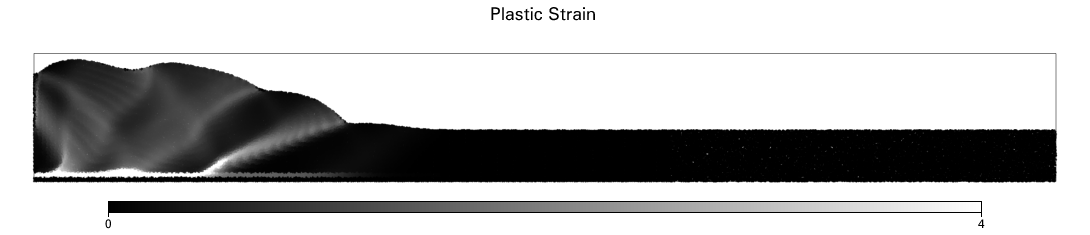

Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.505 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.51 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.515 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.52 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.525 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.53 megayear dt: 0.005 megayear
Processing surface with BasicHillSlopeDiffsuion2d
Processing surface with BasicHillSlopeDiffsuion2d
Time:  4.535 megayear dt: 0.005 megayear
Processing surfa

In [ ]:
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)
Model.run_for(.5 * u.megayears,dt=.005*u.megayear)
plotFigures(fnSize=3)

In [ ]:
figPlots = Model.plot.strainRate(
        figsize=figSize,
        fn_size=fnSize,
        valueRange=[1e-18, 1e-13])
        #
